# Part 3 - RNN and LSTM

## Import libraries

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader

from src import *

## Create dataloader

In [58]:
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
X_train_1, X_test_1 = dataloader.split_by_year([2006, 2007], [2008])

training_dataset_1 = StockTorchDataset(X_train_1, zscore_params=None, history=5)
testing_dataset_1 = StockTorchDataset(X_train_1, zscore_params=training_dataset_1.get_zscore_params(), history=5)

training_loader_1 = DataLoader(training_dataset_1, batch_size=1, shuffle=False, drop_last=False)
testing_loader_1 = DataLoader(testing_dataset_1, batch_size=1, shuffle=False, drop_last=False)

testing

tensor([[-0.0441,  0.2843,  0.0064, -0.2462, -0.1704,  0.3096,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]])
tensor([0.6885])


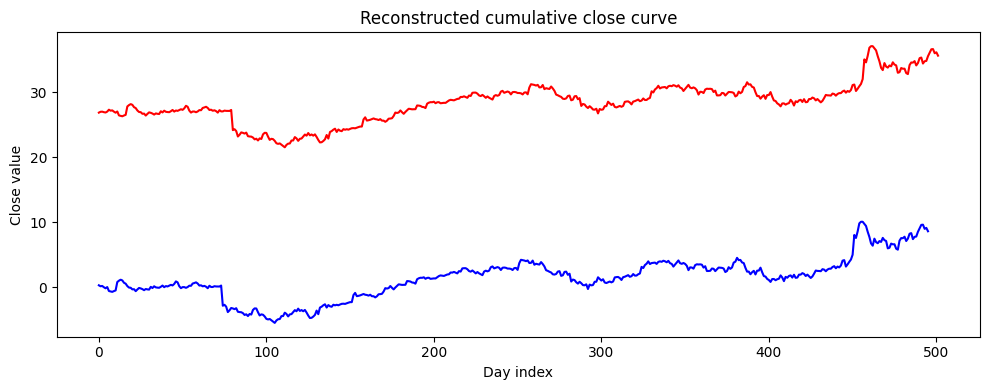

In [59]:
for sample, annotation in training_loader_1:
    print(sample)
    print(annotation)
    break

# Collect standardized targets
std_targets = []
for x, y in training_loader_1:
    std_targets.append(y.item())
std_targets = np.array(std_targets)

# Inverse z-score
inv = std_targets * training_dataset_1.get_zscore_params()[1] + training_dataset_1.get_zscore_params()[0]

# Reconstruct cumulative close curve
curve = np.cumsum(inv)

# Plot
plt.figure(figsize=(10,4))
plt.plot(curve, c="b")
plt.plot(X_train_1[:, 4], c="r")
plt.title("Reconstructed cumulative close curve")
plt.xlabel("Day index")
plt.ylabel("Close value")
plt.tight_layout()

# RNN model

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- RNN Model Definition ---
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1), h

# --- Sliding window loop for RNN ---
years = np.arange(2006, 2018)
history_lengths = [5, 10, 15, 20]
rnn_results = []
print("RNN sliding window results:")
for history_length in history_lengths:
    print(f"\n===== History Length: {history_length} =====")
    rnn_results.append(f"\n===== History Length: {history_length} =====")
    for i in tqdm(range(len(years) - 2)):
        train_years = [years[i], years[i+1]]
        test_year = [years[i+2]]
        # Prepare data
        X_train, X_test = dataloader.split_by_year(train_years, test_year)
        train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length)
        test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length)
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        # Model, optimizer, loss
        input_size = history_length + 1 + 22
        hidden_size = 64
        num_layers = 2
        model = SimpleRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        # Train
        model.train()
        h = None
        accum_steps = 8
        optimizer.zero_grad()
        for epoch in range(20):
            for step, (x, y) in enumerate(train_loader):
                x = x.view(x.size(0), 1, -1)
                output, h = model(x, h)
                loss = criterion(output, y)
                loss.backward()
                h = h.detach()
                if (step + 1) % accum_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
        # Evaluate on train
        model.eval()
        train_preds, train_targets = [], []
        h = None
        with torch.no_grad():
            for x, y in train_loader:
                x = x.view(x.size(0), 1, -1)
                output, h = model(x, h)
                train_preds.append(output.item())
                train_targets.append(y.item())
                h = h.detach()
        train_mae = np.mean(np.abs(np.array(train_preds) - np.array(train_targets)))
        # Evaluate on test
        test_preds, test_targets = [], []
        h = None
        with torch.no_grad():
            for x, y in test_loader:
                x = x.view(x.size(0), 1, -1)
                output, h = model(x, h)
                test_preds.append(output.item())
                test_targets.append(y.item())
                h = h.detach()
        test_mae = np.mean(np.abs(np.array(test_preds) - np.array(test_targets)))
        result_str = f"Train years: {train_years}, Test year: {test_year} | Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}"
        
        rnn_results.append(result_str)
        


RNN sliding window results:

===== History Length: 5 =====


100%|██████████| 10/10 [03:05<00:00, 18.58s/it]



===== History Length: 10 =====


100%|██████████| 10/10 [03:02<00:00, 18.26s/it]



===== History Length: 15 =====


100%|██████████| 10/10 [02:49<00:00, 16.96s/it]



===== History Length: 20 =====


100%|██████████| 10/10 [02:50<00:00, 17.02s/it]


## RNN vizualization


===== History Length: 5 =====
Train years: [np.int64(2006), np.int64(2007)], Test year: [np.int64(2008)] | Train MAE: 0.6175, Test MAE: 1.3952
Train years: [np.int64(2007), np.int64(2008)], Test year: [np.int64(2009)] | Train MAE: 0.6385, Test MAE: 0.6316
Train years: [np.int64(2008), np.int64(2009)], Test year: [np.int64(2010)] | Train MAE: 0.6496, Test MAE: 0.5304
Train years: [np.int64(2009), np.int64(2010)], Test year: [np.int64(2011)] | Train MAE: 0.6641, Test MAE: 0.7287
Train years: [np.int64(2010), np.int64(2011)], Test year: [np.int64(2012)] | Train MAE: 0.7072, Test MAE: 0.8083
Train years: [np.int64(2011), np.int64(2012)], Test year: [np.int64(2013)] | Train MAE: 0.7096, Test MAE: 0.9342
Train years: [np.int64(2012), np.int64(2013)], Test year: [np.int64(2014)] | Train MAE: 0.6495, Test MAE: 0.8394
Train years: [np.int64(2013), np.int64(2014)], Test year: [np.int64(2015)] | Train MAE: 0.6337, Test MAE: 1.0811
Train years: [np.int64(2014), np.int64(2015)], Test year: [np.int

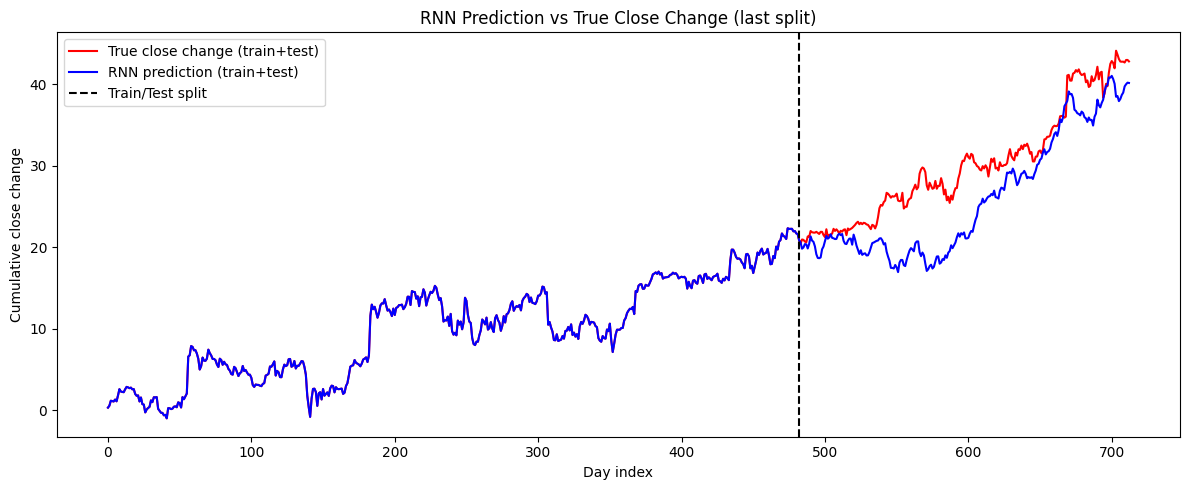

In [61]:
for result in rnn_results:
    print(result) 



# Visualize the last RNN model's predictions (from the last sliding window iteration)
mu, sigma = train_dataset.get_zscore_params()
preds_inv = np.array(test_preds) * sigma + mu
train_targets = []
for _, y in DataLoader(train_dataset, batch_size=1, shuffle=False):
    train_targets.append(y.item())
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma + mu

full_pred = np.concatenate([train_targets_inv, preds_inv])
full_true = np.concatenate([train_targets_inv, np.array(test_targets) * sigma + mu])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="RNN prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"RNN Prediction vs True Close Change (last split)")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()


# LSTM model

In [62]:
# --- LSTM Model Definition ---
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1), h

# --- Sliding window loop for LSTM ---
years = np.arange(2006, 2018)
history_lengths = [5, 10, 15, 20]
lstm_results = []
print("LSTM sliding window results:")
for history_length in history_lengths:
    print(f"\n===== History Length: {history_length} =====")
    lstm_results.append(f"\n===== History Length: {history_length} =====")
    for i in range(len(years) - 2):
        train_years = [years[i], years[i+1]]
        test_year = [years[i+2]]
        # Prepare data
        X_train, X_test = dataloader.split_by_year(train_years, test_year)
        train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length)
        test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length)
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        # Model, optimizer, loss
        input_size = history_length + 1 + 22
        hidden_size = 64
        num_layers = 2
        model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        # Train
        model.train()
        h = None
        accum_steps = 8
        optimizer.zero_grad()
        for epoch in range(20):
            for step, (x, y) in enumerate(train_loader):
                x = x.view(x.size(0), 1, -1)
                output, h = model(x, h)
                loss = criterion(output, y)
                loss.backward()
                h = (h[0].detach(), h[1].detach())
                if (step + 1) % accum_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
        # Evaluate on train
        model.eval()
        train_preds, train_targets = [], []
        h = None
        with torch.no_grad():
            for x, y in train_loader:
                x = x.view(x.size(0), 1, -1)
                output, h = model(x, h)
                train_preds.append(output.item())
                train_targets.append(y.item())
                h = (h[0].detach(), h[1].detach())
        train_mae = np.mean(np.abs(np.array(train_preds) - np.array(train_targets)))
        # Evaluate on test
        test_preds, test_targets = [], []
        h = None
        with torch.no_grad():
            for x, y in test_loader:
                x = x.view(x.size(0), 1, -1)
                output, h = model(x, h)
                test_preds.append(output.item())
                test_targets.append(y.item())
                h = (h[0].detach(), h[1].detach())
        test_mae = np.mean(np.abs(np.array(test_preds) - np.array(test_targets)))
        result_str = f"Train years: {train_years}, Test year: {test_year} | Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}"
        
        lstm_results.append(result_str)


LSTM sliding window results:

===== History Length: 5 =====

===== History Length: 10 =====

===== History Length: 10 =====

===== History Length: 15 =====

===== History Length: 15 =====

===== History Length: 20 =====

===== History Length: 20 =====


## LSTM vizualization


===== History Length: 5 =====
Train years: [np.int64(2006), np.int64(2007)], Test year: [np.int64(2008)] | Train MAE: 0.4445, Test MAE: 1.5697
Train years: [np.int64(2007), np.int64(2008)], Test year: [np.int64(2009)] | Train MAE: 0.4968, Test MAE: 0.6494
Train years: [np.int64(2008), np.int64(2009)], Test year: [np.int64(2010)] | Train MAE: 0.5243, Test MAE: 0.5688
Train years: [np.int64(2009), np.int64(2010)], Test year: [np.int64(2011)] | Train MAE: 0.5922, Test MAE: 0.9276
Train years: [np.int64(2010), np.int64(2011)], Test year: [np.int64(2012)] | Train MAE: 0.4970, Test MAE: 0.9552
Train years: [np.int64(2011), np.int64(2012)], Test year: [np.int64(2013)] | Train MAE: 0.4749, Test MAE: 1.1152
Train years: [np.int64(2012), np.int64(2013)], Test year: [np.int64(2014)] | Train MAE: 0.5480, Test MAE: 0.9756
Train years: [np.int64(2013), np.int64(2014)], Test year: [np.int64(2015)] | Train MAE: 0.4740, Test MAE: 1.2606
Train years: [np.int64(2014), np.int64(2015)], Test year: [np.int

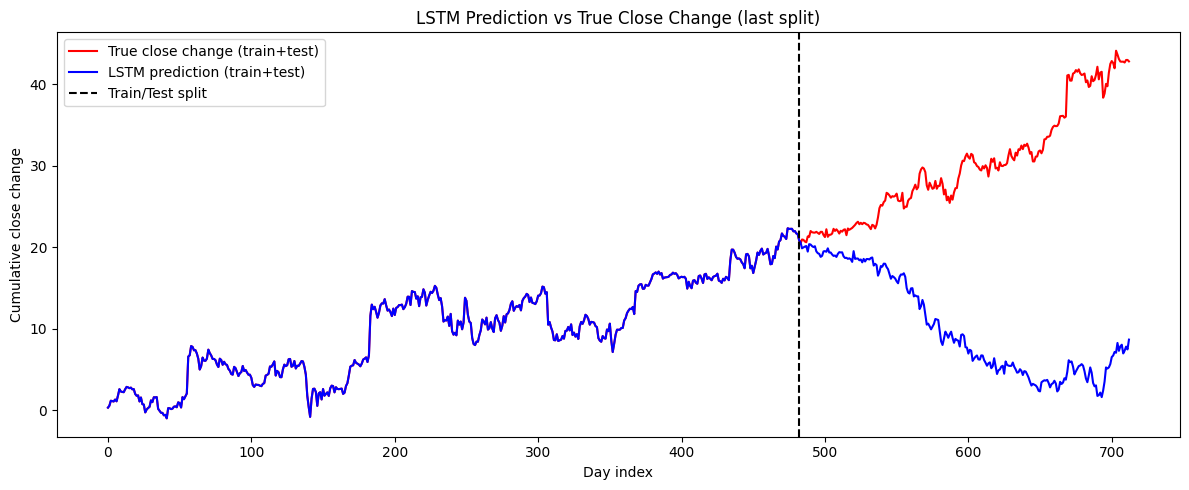

In [63]:
for result in lstm_results:
    print(result) 


# Visualize the last LSTM model's predictions (from the last sliding window iteration)
mu, sigma = train_dataset.get_zscore_params()
preds_inv = np.array(test_preds) * sigma + mu
train_targets = []
for _, y in DataLoader(train_dataset, batch_size=1, shuffle=False):
    train_targets.append(y.item())
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma + mu

full_pred = np.concatenate([train_targets_inv, preds_inv])
full_true = np.concatenate([train_targets_inv, np.array(test_targets) * sigma + mu])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="LSTM prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"LSTM Prediction vs True Close Change (last split)")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()
